In [324]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

## Questions
1. How to compute zero crossing in 2d array
2. What threshold to use in sobel and in general


# Convolution

## 1D Convolution

In [2]:
# Convolves a 1D array with a kernel
def conv1D(inSignal:np.ndarray,kernel1:np.ndarray)->np.ndarray:
    if(kernel1.shape[0] % 2 == 0):
        pad_size = int((kernel1.shape[0])/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(0, padded_signal.shape[0]-pad_size-1):
            sub_signal = padded_signal[i:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    else:
        # Padding array with zeros so resulting array is same length as original
        pad_size = int((kernel1.shape[0]-1)/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(pad_size, padded_signal.shape[0]-pad_size):
            sub_signal = padded_signal[i-pad_size:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    return new_signal

In [3]:
conv1D(np.array([1,1]),np.array([1,1]))

array([1., 2.])

In [4]:
np.convolve(np.array([1,1]),np.array([1,1]),'same')

array([1, 2])

## 2D Convolution

In [5]:
def conv2D(inImage:np.ndarray,kernel2:np.ndarray)->np.ndarray:
    pad_size = int((kernel2.shape[0]-1)/2)
#     padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'constant', constant_values=0)
    padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'reflect')
    new_image = np.zeros(padded_image.shape)
    for i in range(pad_size, padded_image.shape[0]-pad_size):
        for j in range(pad_size, padded_image.shape[1]-pad_size):
            sub_image = padded_image[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]
            prod = sub_image*kernel2
            sub_image_sum = np.sum(prod)
            new_image[i,j] = sub_image_sum
    return new_image[pad_size:-pad_size,pad_size:-pad_size]

In [6]:
def mean_ker(size):
    return np.full((size,size),1)/(size*size)

(400, 400)

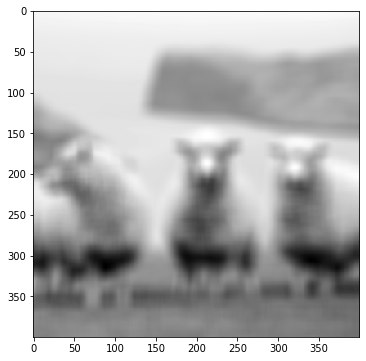

In [325]:
img = cv2.imread("sheep.png",0)
ker = mean_ker(19)
ker = ker/np.sum(ker)
res = conv2D(img,ker)
plt.imshow(res,'gray')
res.shape

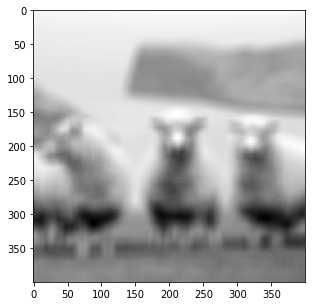

In [304]:
res2 = cv2.filter2D(img,-1,ker)
plt.imshow(res2,'gray')

0.49861495844879755

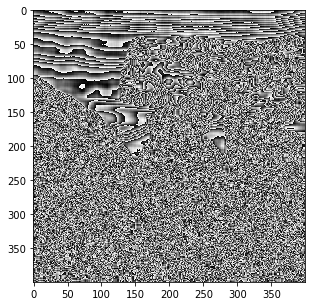

In [305]:
plt.imshow(res2-res,'gray')
np.max(res2-res) # max pixel value diff between my result and opencv's

# Image derivatives & blurring

## Derivatives

In [306]:
def convDerivative(inImage:np.ndarray) -> np.ndarray:
    ker = np.array([1,0,-1])
    h,w = inImage.shape[:2]
    der_x = conv2D(inImage,ker)
    der_y = conv2D(inImage, np.reshape(ker,(3,1)))
    mag = np.sqrt(der_x**2 + der_y**2)
    return mag

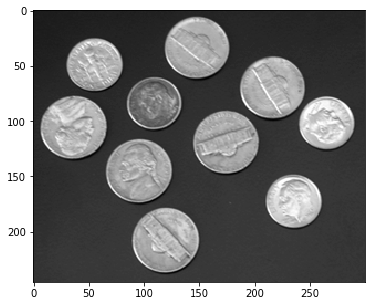

In [307]:
img = cv2.imread('coins.png',0)
plt.imshow(img,'gray')

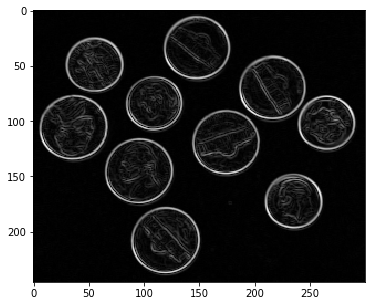

In [308]:
img = cv2.imread('coins.png',0)
plt.imshow(convDerivative(img),'gray')

## Blurring

0.9999999999999999

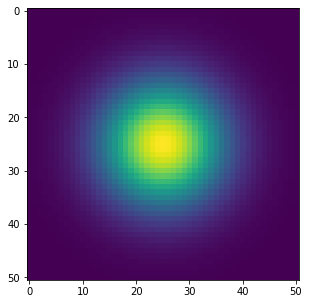

In [309]:
def gauss_row(size):
    arr = np.array([1,1])
    ker = np.array([1,1])
    for i in range(size-2):
        arr = np.convolve(arr,ker)
    return arr/np.sum(arr)

def G(x,y,sigma):
    return (1/2*np.pi*sigma*sigma)*np.e**(-(x**2+y**2)/2*sigma**2)

def gauss(size):
    sigma = 1/(0.3*((size-1)*0.5 - 1) + 0.8)
    mat = np.zeros((size,size))
    center = np.ceil(size/2)-1
    for i in range(size):
        for j in range(size):
            mat[i,j] = G(np.abs(i-center),np.abs(j-center),sigma)
    return mat/np.sum(mat)

plt.imshow(gauss(51))
np.sum(gauss(51))

In [310]:
def blurImage1(inImage:np.ndarray,kernelSize:np.ndarray)->np.ndarray:
    new_image = np.zeros(inImage.shape)
    channels = 1
    if len(inImage.shape) == 3:
        channels = inImage.shape[2]
    ker = []
    for i in range(kernelSize.shape[0]):
        ker.append(gauss(kernelSize[i]))
    ker = np.array(ker)
    if(channels > 1):
        for i in range(inImage.shape[2]):
            new_image[:,:,i] = conv2D(new_image[:,:,i],ker[i])
    else:
         new_image = conv2D(inImage,ker[0])
    return new_image

def blurImage2(inImage:np.ndarray,kernelSize:np.ndarray)->np.ndarray:
    channels = 1
    if len(inImage.shape) == 3:
        channels = inImage.shape[2]
    ker = []
    for i in range(kernelSize.shape[0]):
        ker.append(cv2.getGaussianKernel(kernelSize[i],-1))
    ker = np.array(ker)
    if(channels > 1):
        for i in range(inImage.shape[2]):
            inImage[:,:,i] = cv2.filter2D(inImage[:,:,i],-1,ker[i])
        inImage = np.transpose(inImage)
        for i in range(inImage.shape[2]):
            inImage[:,:,i] = cv2.filter2D(inImage[:,:,i],-1,ker[i])
    else:
        inImage = cv2.filter2D(inImage,-1,ker[0])
        inImage = np.transpose(inImage)
        inImage = cv2.filter2D(inImage,-1,ker[0])
    return np.transpose(inImage)

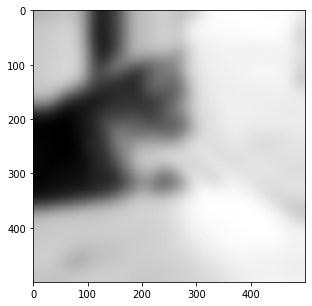

In [311]:
img = cv2.imread("cat.jpg",0)
res1 = blurImage1(img,np.array([101]))
plt.imshow(res1,'gray')

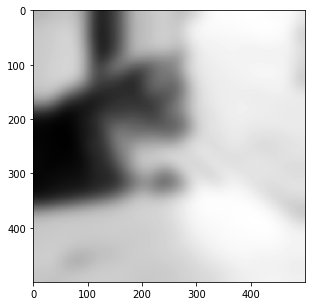

In [312]:
img = cv2.imread("cat.jpg",0)
res2 = blurImage2(img,np.array([101]))
plt.imshow(res2,'gray')

0.6827559369997402

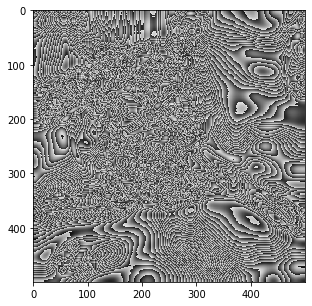

In [313]:
plt.imshow(res2-res1,'gray')
np.max(res2-res1)

## Edge detection

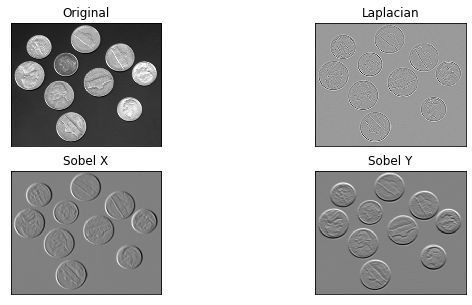

In [314]:
img = cv2.imread('coins.png',0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

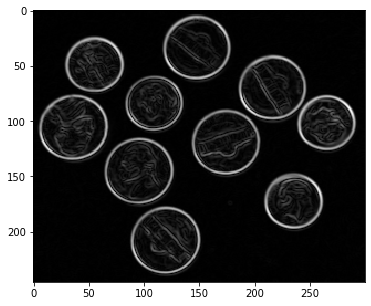

In [315]:
plt.imshow(np.sqrt(sobely**2+sobelx**2),cmap = 'gray')

In [316]:
def edgeDetectionSobel(I:np.ndarray)->(np.ndarray,np.ndarray):
    ker_grad = np.array([1,0,-1])
    ker_gauss = np.array([1,2,1])
    h,w = I.shape[:2]
    der_x = conv2D(I,ker_grad)
    der_x = conv2D(der_x,ker_gauss)
    der_y = conv2D(I, np.reshape(ker_grad,(3,1)))
    der_y = conv2D(der_y, np.reshape(ker_gauss,(3,1)))
    mag = np.sqrt(der_x**2 + der_y**2)
    mag2 = cv2.normalize(mag,mag,0.0,1.0,cv2.NORM_MINMAX, cv2.CV_32FC1)
    for i in range(h):
        for j in range(w):
            if mag2[i,j] > 0.3:
                mag2[i,j] = 1
            else:
                mag2[i,j] = 0
    return (mag2,mag)

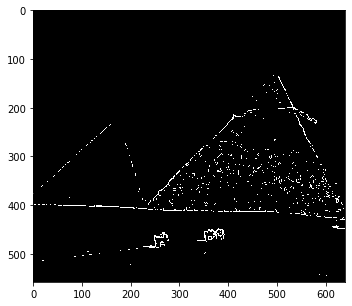

In [317]:
img = cv2.imread('pyramids.png',0)
res = edgeDetectionSobel(img)[0]
plt.imshow(res,'gray')

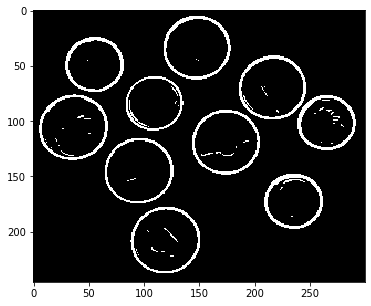

In [318]:
img = cv2.imread('coins.png',0)
res = edgeDetectionSobel(img)[0]
plt.imshow(res,'gray')

In [319]:
def edgeDetectionZeroCrossing(I:np.ndarray)->(np.ndarray,np.ndarray):
    ker_grad2 = np.array([1,-2,1])
    ker_gauss = np.array([1,2,1])
    h,w = I.shape[:2]
    der_x = conv2D(I,ker_grad2)
    der_x = conv2D(der_x,ker_gauss)
    der_y = conv2D(I, np.reshape(ker_grad2,(3,1)))
    der_y = conv2D(der_y, np.reshape(ker_gauss,(3,1)))
    mag = np.sqrt(der_x**2 + der_y**2)
    mag2 = cv2.normalize(mag,mag,0.0,1.0,cv2.NORM_MINMAX, cv2.CV_32FC1)
    for i in range(h):
        for j in range(w):
            if mag2[i,j] > 0.3:
                mag2[i,j] = 1
            else:
                mag2[i,j] = 0
    return (mag2,mag)

(Text(0.5, 1.0, 'Zero crossing'),)

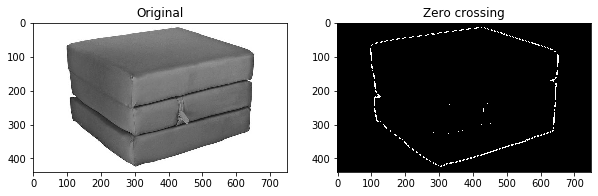

In [327]:
img = cv2.imread('cube.jfif',0)
res = edgeDetectionZeroCrossing(img)[0]
plt.subplot(1,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), #plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res,cmap = 'gray')
plt.title('Zero crossing'), #plt.xticks([]), plt.yticks([])